In [2]:
import requests
from tqdm import tqdm
import zipfile
import os
import numpy as np
import wfdb
import neurokit2 as nk

In [4]:
def download_file(url, filename):
    chunkSize = 1024
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        pbar = tqdm(unit="B", total=int(r.headers['Content-Length']))
        for chunk in r.iter_content(chunk_size=chunkSize): 
            if chunk:
                pbar.update(len(chunk))
                f.write(chunk)
    return filename

In [7]:
def downloadextract_ECGfiles(zippath="data/ecg.zip", targetpath="data/ecg", redownload=False):
    if os.path.exists(targetpath) and not redownload:
        print("ECG files already exist")
        return

    os.makedirs("data", exist_ok=True)
    link = "https://physionet.org/static/published-projects/afdb/mit-bih-atrial-fibrillation-database-1.0.0.zip"
    print("Downloading ECG files (440 MB) ...")
    download_file(link, zippath)

    print("Unzipping ECG files ...")
    with zipfile.ZipFile(zippath, "r") as zip_ref:
        zip_ref.extractall(targetpath)
    os.remove(zippath)
    print("Done extracting and downloading")

In [8]:
downloadextract_ECGfiles()

100%|██████████| 461033254/461033254 [24:15<00:00, 316823.57B/s]


Unzipping ECG files ...
Done extracting and downloading


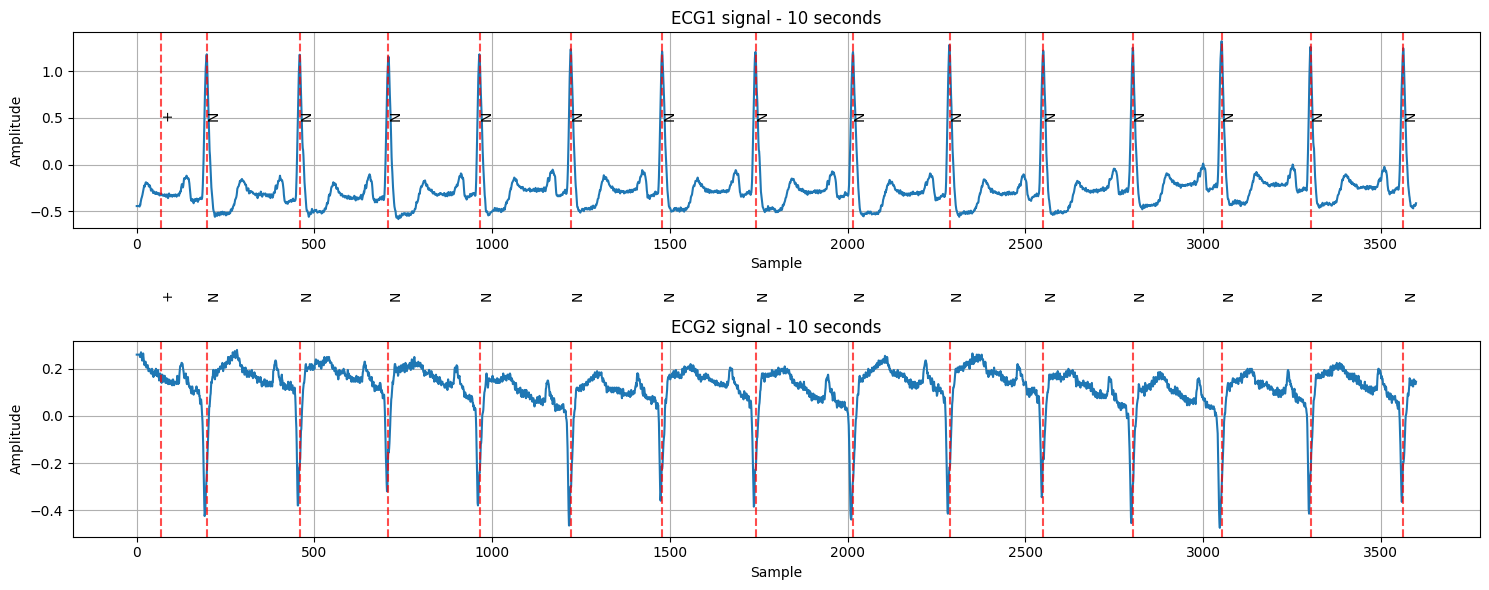

In [3]:
import wfdb
import matplotlib.pyplot as plt

FILE_NUMBER = '105'

fileName = F'mit-bih-arrhythmia-database-1.0.0/{FILE_NUMBER}'
record = wfdb.rdrecord(fileName)
annotation = wfdb.rdann(fileName, 'atr')

FS = record.fs
SECONDS = 10

samples = annotation.sample
labels = annotation.symbol

plt.figure(figsize=(15, 6))

# ECG1
plt.subplot(2, 1, 1) 
plt.plot(record.p_signal[:FS*SECONDS, 0])
plt.title(F"ECG1 signal - {SECONDS} seconds")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)

for sample, label in zip(samples, labels):
    if sample < FS * SECONDS:  # Chỉ vẽ các annotation trong phạm vi 10 giây
        plt.axvline(x=sample, color='r', linestyle='--', alpha=0.7)  # Đường thẳng đỏ
        plt.text(sample, 0.5, label, fontsize=10, color='black', rotation=90)  # Hiển thị nhãn



# ECG2
plt.subplot(2, 1, 2)  
plt.plot(record.p_signal[:FS*SECONDS, 1])
plt.title(F"ECG2 signal - {SECONDS} seconds")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)

for sample, label in zip(samples, labels):
    if sample < FS * SECONDS:  
        plt.axvline(x=sample, color='r', linestyle='--', alpha=0.7) 
        plt.text(sample, 0.5, label, fontsize=10, color='black', rotation=90)  


plt.tight_layout()
plt.show()


In [4]:
print("Tần số lấy mẫu (Hz):", record.fs)
print("Số tín hiệu (kênh):", record.n_sig)
print("Số mẫu tổng cộng:", len(record.p_signal))
print("Kích thước tín hiệu:", record.p_signal.shape)
print("Tên các kênh đo:", record.sig_name)


Tần số lấy mẫu (Hz): 360
Số tín hiệu (kênh): 2
Số mẫu tổng cộng: 650000
Kích thước tín hiệu: (650000, 2)
Tên các kênh đo: ['MLII', 'V1']


In [5]:
np.unique(annotation.symbol)

array(['+', 'N', 'Q', 'V', '|', '~'], dtype='<U1')

In [6]:
from collections import Counter

abnormal_labels = {"V", "A", "L", "R", "!", "f", "F", "j", "E", "J", "a"} 

def represent_label(labels):
    label_counts = Counter(labels)

    # Lọc nhãn bệnh ra khỏi danh sách
    abnormal_counts = {k: v for k, v in label_counts.items() if k in abnormal_labels}

    if abnormal_counts:
        # Nếu có nhãn bệnh, chọn nhãn bệnh xuất hiện nhiều nhất
        representative_label = max(abnormal_counts, key=abnormal_counts.get)
    else:
        # Nếu không có nhãn bệnh, chọn nhãn phổ biến nhất
        representative_label = max(label_counts, key=label_counts.get)
    return representative_label

In [ ]:
import wfdb
import numpy as np
import os
from tqdm import tqdm

data_dir = "mit-bih-arrhythmia-database-1.0.0" 
fs = 360 
segment_length = 10 * fs 

all_segments = []
all_labels = []

dat_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".dat")])

for file in tqdm(dat_files, desc="Processing files"):
    record_name = file.split(".")[0]  

    #ECG
    record = wfdb.rdrecord(os.path.join(data_dir, record_name))
    signal = record.p_signal

    # annotation
    annotation = wfdb.rdann(os.path.join(data_dir, record_name), "atr")
    r_peaks = annotation.sample  
    labels = annotation.symbol 

    for i in range(0, len(signal) - segment_length, segment_length//2):
        segment = signal[i : i + segment_length]
        segment_r_peaks  = r_peaks[(r_peaks >= i) & (r_peaks < i + segment_length)]
        
        segment_labels = []
        for r in segment_r_peaks:
            idx = np.searchsorted(annotation.sample, r)
            if idx < len(labels):
                segment_labels.append(labels[idx])
        
        if len(segment_labels) == 0:
            continue
        segment_label = represent_label(segment_labels) 

        all_segments.append(segment)
        all_labels.append(segment_label)
        # print(segment_label)

all_segments = np.array(all_segments)
all_labels = np.array(all_labels)


Processing files: 100%|██████████| 48/48 [00:03<00:00, 14.42it/s]


In [15]:
all_segments[13]

array([[-0.22 , -0.305],
       [-0.22 , -0.3  ],
       [-0.23 , -0.305],
       ...,
       [-0.4  , -0.26 ],
       [-0.41 , -0.27 ],
       [-0.415, -0.285]], shape=(3600, 2))

In [9]:
Counter(all_labels)

Counter({np.str_('N'): 7966,
         np.str_('V'): 3931,
         np.str_('L'): 1343,
         np.str_('R'): 1261,
         np.str_('A'): 980,
         np.str_('/'): 706,
         np.str_('f'): 536,
         np.str_('F'): 252,
         np.str_('a'): 110,
         np.str_('j'): 95,
         np.str_('!'): 34,
         np.str_('"'): 32,
         np.str_('E'): 21,
         np.str_('J'): 13})

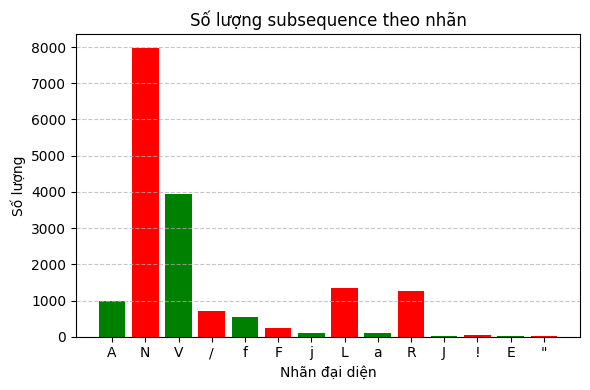

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(all_labels)

plt.figure(figsize=(6, 4))
plt.bar(label_counts.keys(), label_counts.values(), color=['green', 'red'])
plt.title("Số lượng subsequence theo nhãn")
plt.xlabel("Nhãn đại diện")
plt.ylabel("Số lượng")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


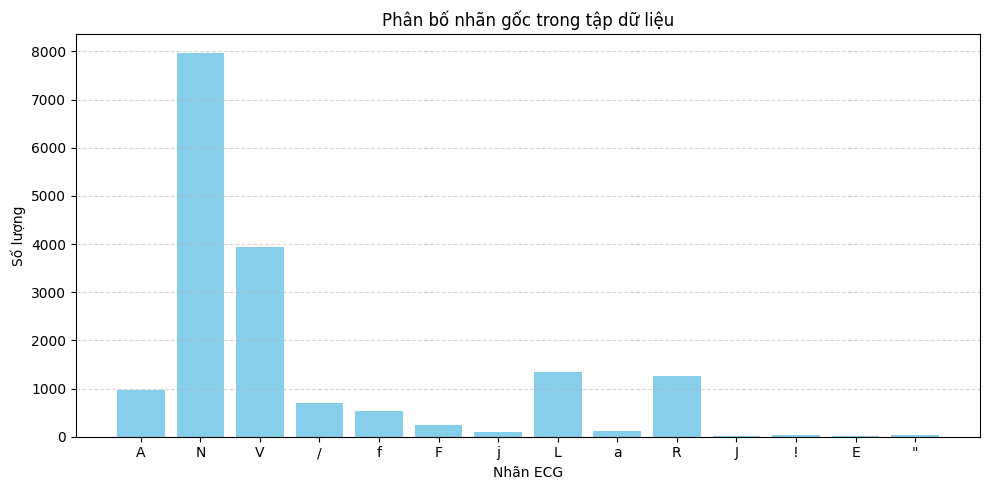

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

label_counts = Counter(all_labels)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Phân bố nhãn gốc trong tập dữ liệu")
plt.xlabel("Nhãn ECG")
plt.ylabel("Số lượng")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [17]:
import numpy as np

np.save("all_segments.npy", all_segments)
np.save("all_labels.npy", all_labels)


In [18]:
all_segments = np.load("all_segments.npy", allow_pickle=True)
all_labels = np.load("all_labels.npy", allow_pickle=True)

In [19]:
import numpy as np
import neurokit2 as nk

def preprocess_subsequences(subsequences, sampling_rate=360):
    processed_subseqs = []

    for subseq in subsequences:
        denoised = np.zeros_like(subseq)

        # Lọc nhiễu từng kênh
        for channel in range(subseq.shape[1]):
            denoised[:, channel] = nk.ecg_clean(subseq[:, channel], sampling_rate=sampling_rate)

        # Z-score normalization theo kênh
        mean = np.mean(denoised, axis=0)
        std = np.std(denoised, axis=0)
        normalized = (denoised - mean) / std

        processed_subseqs.append(normalized)

    return np.array(processed_subseqs)


In [20]:
processed_segments = preprocess_subsequences(all_segments)

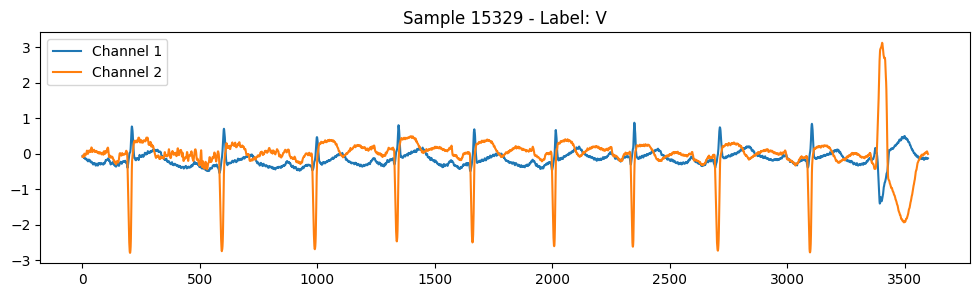

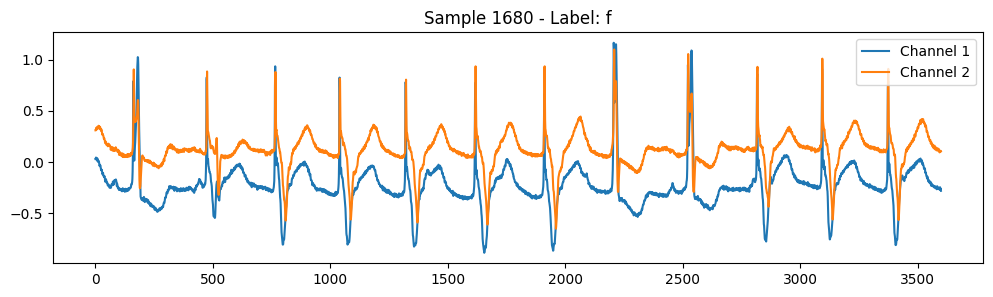

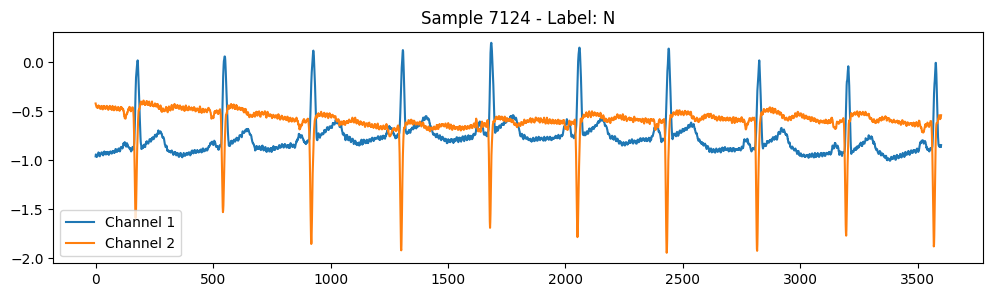

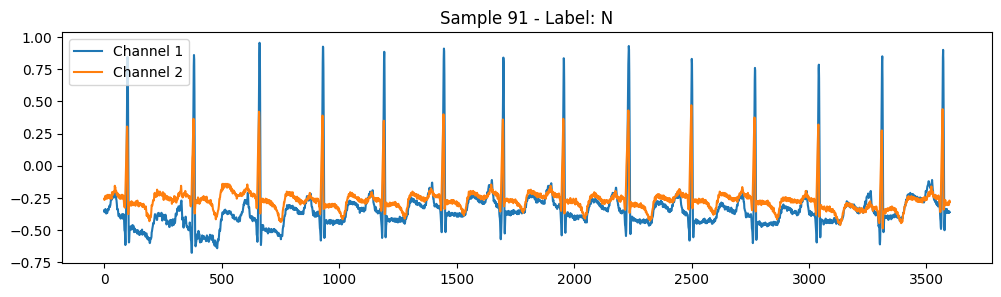

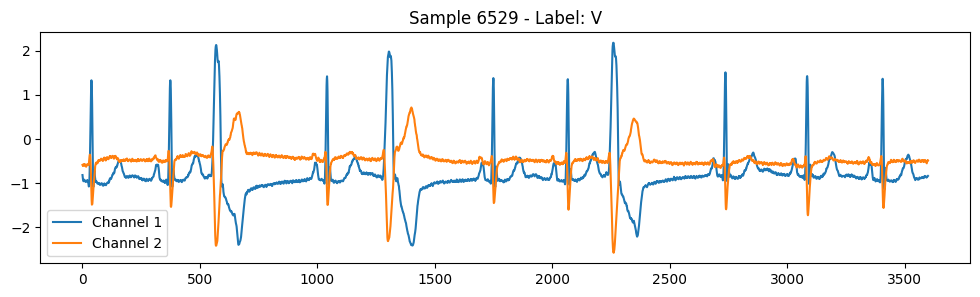

In [24]:
import seaborn as sns

for i in range(5):
    idx = np.random.randint(0, len(all_segments))
    sample = all_segments[idx]

    plt.figure(figsize=(12, 3))
    plt.title(f"Sample {idx} - Label: {all_labels[idx]}")
    plt.plot(sample[:, 0], label="Channel 1")
    plt.plot(sample[:, 1], label="Channel 2")
    plt.legend()
    plt.show()


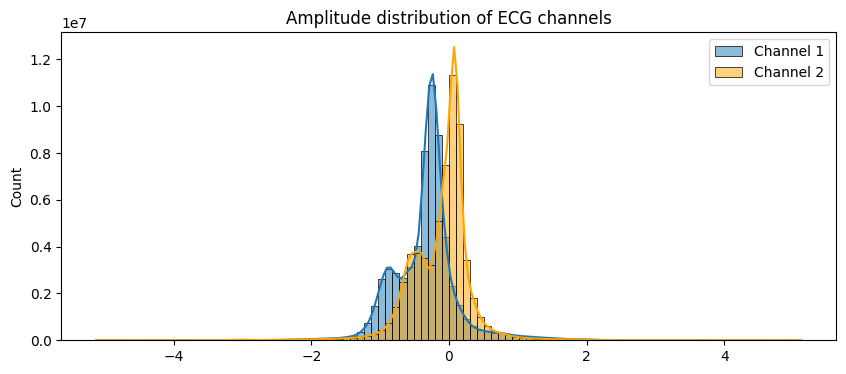

In [25]:
flattened = all_segments.reshape(-1, 2)
plt.figure(figsize=(10, 4))
sns.histplot(flattened[:, 0], bins=100, kde=True, label='Channel 1')
sns.histplot(flattened[:, 1], bins=100, kde=True, label='Channel 2', color='orange')
plt.legend()
plt.title("Amplitude distribution of ECG channels")
plt.show()


In [29]:
import numpy as np

dtype = [('segment', np.float32, all_segments.shape[1:]), ('label', 'U10')]
structured_array = np.array(list(zip(all_segments, all_labels)), dtype=dtype)


In [34]:
structured_array[0]

np.void(([[-0.145, -0.065], [-0.145, -0.065], [-0.145, -0.065], ..., [-0.39, -0.295], [-0.4, -0.29], [-0.405, -0.285]], 'A'), dtype=[('segment', '<f4', (3600, 2)), ('label', '<U10')])

In [35]:
np.save("processed_ecg_segments.npy", structured_array)

In [38]:
np.unique(structured_array['label'])

array(['!', '"', '/', 'A', 'E', 'F', 'J', 'L', 'N', 'R', 'V', 'a', 'f',
       'j'], dtype='<U10')

In [43]:
len(structured_array)

17280

In [46]:
valid_labels = ['N', 'L', 'R', 'A', 'V', 'F', 'j', 'E','!','J', 'a']
filtered_data = structured_array[np.isin(structured_array['label'], valid_labels)]

In [56]:
Counter(filtered_data['label'])


Counter({np.str_('N'): 7966,
         np.str_('V'): 3931,
         np.str_('L'): 1343,
         np.str_('R'): 1261,
         np.str_('A'): 980,
         np.str_('F'): 252,
         np.str_('a'): 110,
         np.str_('j'): 95,
         np.str_('!'): 34,
         np.str_('E'): 21,
         np.str_('J'): 13})

In [60]:
def merge_label(data):
    label = data['label']
    new_label = ''
    if label in ['N']:
        new_label = 'Normal'
    elif label in ['L','R']:
        new_label = 'Bundle branch block'
    elif label in ['A','a','J']:
        new_label = 'Supraventricular ectopic'
    elif label in ['V', 'F', '!']:
        new_label = 'Ventricular ectopic'
    elif label in ['j', 'E']:
        new_label = 'escape'
    data['label'] = new_label
    return data

In [61]:
merged_labels_data = np.array([merge_label(data) for data in filtered_data])

In [63]:
Counter(merged_labels_data['label'])

Counter({np.str_('Normal'): 7966,
         np.str_('Ventricula'): 4217,
         np.str_('Bundle bra'): 2604,
         np.str_('Supraventr'): 1103,
         np.str_('escape'): 116})

In [65]:
merged_labels_data

array([([[-0.145, -0.065], [-0.145, -0.065], [-0.145, -0.065], ..., [-0.39 , -0.295], [-0.4  , -0.29 ], [-0.405, -0.285]], 'Supraventr'),
       ([[-0.535, -0.05 ], [-0.505,  0.085], [-0.415,  0.195], ..., [-0.365, -0.255], [-0.375, -0.265], [-0.375, -0.26 ]], 'Supraventr'),
       ([[-0.39 , -0.275], [-0.395, -0.265], [-0.39 , -0.285], ..., [-0.425, -0.4  ], [-0.43 , -0.42 ], [-0.42 , -0.4  ]], 'Normal'),
       ...,
       ([[-0.22 ,  0.01 ], [-0.205,  0.03 ], [-0.215,  0.035], ..., [-0.42 ,  0.005], [-0.41 , -0.01 ], [-0.395, -0.025]], 'Normal'),
       ([[-0.2  ,  0.185], [-0.215,  0.165], [-0.21 ,  0.17 ], ..., [-0.235,  0.16 ], [-0.24 ,  0.165], [-0.25 ,  0.155]], 'Normal'),
       ([[-0.395, -0.015], [-0.4  , -0.005], [-0.42 , -0.015], ..., [-0.395,  0.005], [-0.38 , -0.01 ], [-0.385,  0.01 ]], 'Normal')],
      shape=(16006,), dtype=[('segment', '<f4', (3600, 2)), ('label', '<U10')])

In [66]:
np.save("data_tranning.npy", merged_labels_data)